In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import utils
import cleaning
import plotting
sns.set(font_scale=1.25)

In [2]:
tn = pd.read_csv(os.path.join('zippedData', 'tn.movie_budgets.csv.gz'), parse_dates=['release_date'])

del tn['id']
tn.insert(0, 'tn_id', np.arange(tn.shape[0]) + 1)
tn.insert(2, 'release_year', tn['release_date'].dt.year)
tn

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...,...
5777,5778,2018-12-31,2018,Red 11,"$7,000",$0,$0
5778,5779,1999-04-02,1999,Following,"$6,000","$48,482","$240,495"
5779,5780,2005-07-13,2005,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,5781,2015-09-29,2015,A Plague So Pleasant,"$1,400",$0,$0


In [3]:
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[money_cols] = (tn.loc[:, money_cols]
                    .apply(cleaning.process_strings)
                    .apply(lambda x: x.astype('int64')))
tn = tn.loc[tn.query('(domestic_gross > 0) & (worldwide_gross > 0)').index]
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5770,5771,2008-08-14,2008,The Rise and Fall of Miss Thang,10000,401,401
5518,5519,2005-10-13,2005,The Dark Hours,400000,423,423
5769,5770,1996-04-01,1996,Bang,10000,527,527
5466,5467,2018-05-11,2018,Higher Power,500000,528,528
5027,5028,1993-01-01,1993,Ed and his Dead Mother,1800000,673,673


Text(0.5, 0, 'Year')

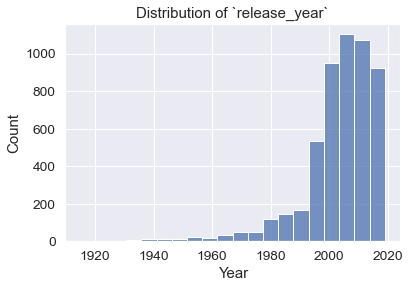

In [4]:
ax = sns.histplot(data=tn, x='release_year', bins=20)
ax.set_title('Distribution of `release_year`')
ax.set_xlabel('Year')

In [5]:
tn = tn.loc[tn.query('(release_year <= 2019) & (release_year >= 2009)').index]
tn

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,2009,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,2019,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,2015,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...,...
5737,5738,2016-03-18,2016,Krisha,30000,144822,144822
5740,5741,2010-10-15,2010,Down Terrace,30000,9812,9812
5744,5745,2017-01-27,2017,Emily,27000,3547,3547
5760,5761,2010-04-02,2010,Breaking Upwards,15000,115592,115592


array([<AxesSubplot:title={'center':'Distribution of `production_budget`'}, xlabel='Dollars', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `domestic_gross`'}, xlabel='Dollars', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `worldwide_gross`'}, xlabel='Dollars', ylabel='Count'>],
      dtype=object)

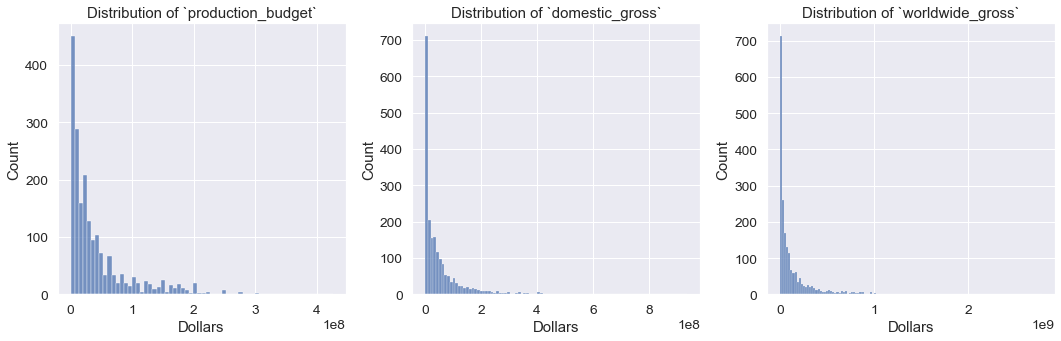

In [6]:
plotting.multi_hist(tn, include=money_cols, xlabel='Dollars')

Text(0, 0.5, 'Dollars (billions)')

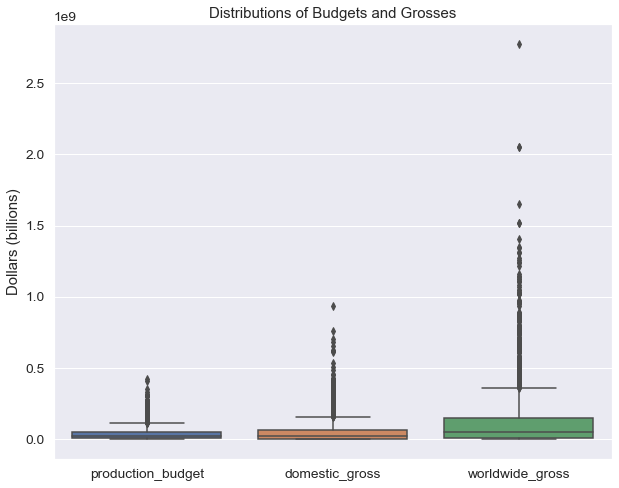

In [7]:
fix, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=tn[money_cols], ax=ax)
ax.set_title('Distributions of Budgets and Grosses')
ax.set_ylabel('Dollars (billions)')

In [8]:
tn['worldwide_profit'] = tn.eval('worldwide_gross - production_budget')
tn['domestic_profit'] = tn.eval('domestic_gross - production_budget')
money_cols += ['worldwide_profit', 'domestic_profit']
tn.sort_values('worldwide_profit', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
0,1,2009-12-18,2009,Avatar,425000000,760507625,2776345279,2351345279,335507625
6,7,2018-04-27,2018,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,378815482
5,6,2015-12-18,2015,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,630662225
33,34,2015-06-12,2015,Jurassic World,215000000,652270625,1648854864,1433854864,437270625
66,67,2015-04-03,2015,Furious 7,190000000,353007020,1518722794,1328722794,163007020


array([<AxesSubplot:title={'center':'Distribution of `domestic_profit`'}, xlabel='Dollars', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `worldwide_profit`'}, xlabel='Dollars', ylabel='Count'>],
      dtype=object)

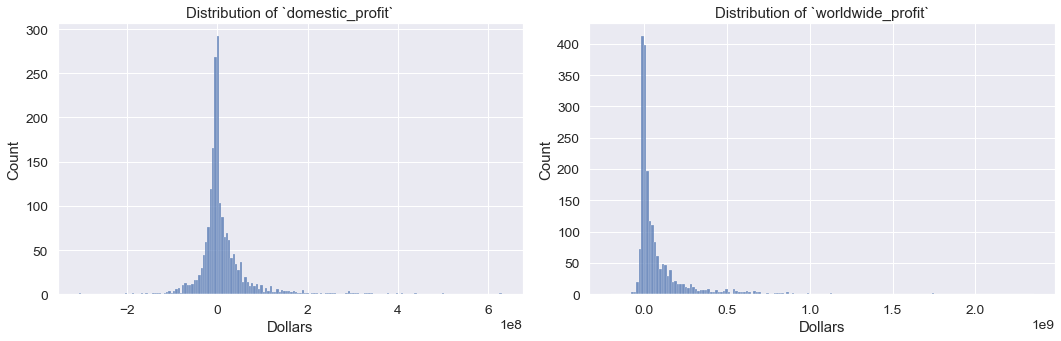

In [9]:
plotting.multi_hist(tn, include=['domestic_profit', 'worldwide_profit'], xlabel='Dollars')

In [10]:
tn['worldwide_roi'] = tn.eval('(worldwide_profit / production_budget) * 100')
tn['domestic_roi'] = tn.eval('(domestic_profit / production_budget) * 100')
money_cols += ['worldwide_roi', 'domestic_roi']
tn.sort_values('worldwide_roi', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
5492,5493,2009-09-25,2009,Paranormal Activity,450000,107918810,194183034,193733034,107468810,43051.785333,23881.957778
5679,5680,2015-07-10,2015,The Gallows,100000,22764410,41656474,41556474,22664410,41556.474000,22664.410000
5211,5212,2012-01-06,2012,The Devil Inside,1000000,53262945,101759490,100759490,52262945,10075.949000,5226.294500
5459,5460,2009-04-23,2009,Home,500000,15433,44793168,44293168,-484567,8858.633600,-96.913400
5062,5063,2011-04-01,2011,Insidious,1500000,54009150,99870886,98370886,52509150,6558.059067,3500.610000


array([<AxesSubplot:title={'center':'Distribution of `domestic_roi`'}, xlabel='Percent', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `worldwide_roi`'}, xlabel='Percent', ylabel='Count'>],
      dtype=object)

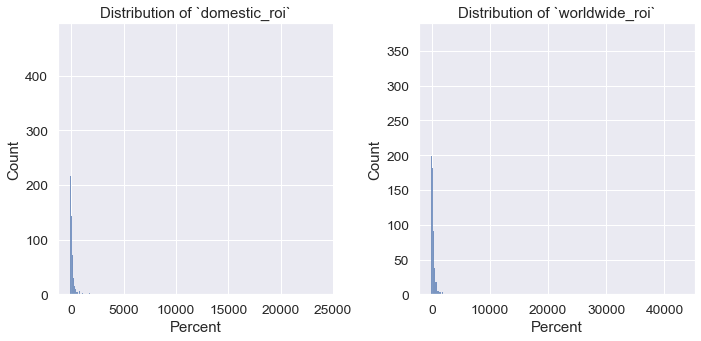

In [11]:
plotting.multi_hist(tn, include=['domestic_roi', 'worldwide_roi'], figsize=(10, 5), xlabel='Percent')

Text(0, 0.5, 'Percent')

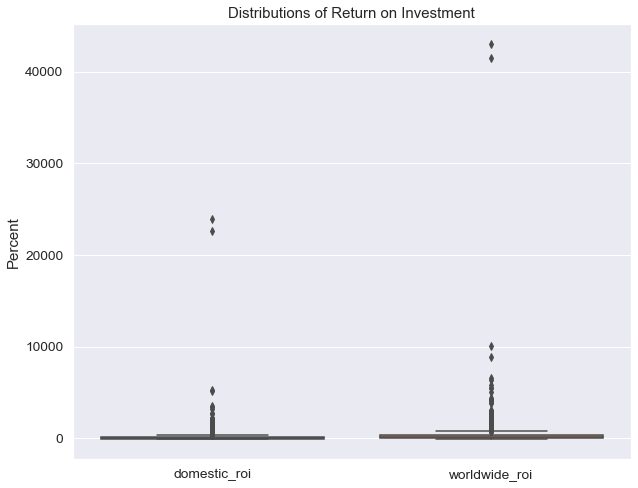

In [12]:
fix, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=tn[['domestic_roi', 'worldwide_roi']], ax=ax)
ax.set_title('Distributions of Return on Investment')
ax.set_ylabel('Percent')

In [13]:
cleaning.info(tn)

,dup,dup_%,nan,nan_%
tn_id,0,0.000000,0,0.0
release_date,1329,66.716867,0,0.0
release_year,1981,99.447791,0,0.0
movie,4,0.200803,0,0.0
production_budget,1687,84.688755,0,0.0
domestic_gross,0,0.000000,0,0.0
worldwide_gross,0,0.000000,0,0.0
worldwide_profit,0,0.000000,0,0.0
domestic_profit,0,0.000000,0,0.0
worldwide_roi,1,0.050201,0,0.0


In [14]:
tn[tn[['movie']].duplicated(keep=False)]

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
38,39,2010-05-14,2010,Robin Hood,210000000,105487148,322459006,112459006,-104512852,53.551908,-49.768025
243,244,2015-03-27,2015,Home,130000000,177397510,385997896,255997896,47397510,196.921458,36.459623
408,409,2018-11-21,2018,Robin Hood,99000000,30824628,84747441,-14252559,-68175372,-14.396524,-68.864012
2140,2141,2009-12-04,2009,Brothers,26000000,28544157,45043870,19043870,2544157,73.245654,9.785219
3307,3308,2015-08-14,2015,Brothers,13000000,656688,17856688,4856688,-12343312,37.359138,-94.948554
5009,5010,2010-04-09,2010,The Square,1900000,406216,740932,-1159068,-1493784,-61.003579,-78.620211
5099,5100,2013-10-25,2013,The Square,1500000,124244,176262,-1323738,-1375756,-88.249200,-91.717067
5459,5460,2009-04-23,2009,Home,500000,15433,44793168,44293168,-484567,8858.633600,-96.913400


In [15]:
tn.to_json(os.path.join('precomputed', 'tn.profit.json'))

In [16]:
imdb = pd.read_csv(os.path.join('zippedData', 'imdb.title.basics.csv.gz'))
imdb

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [17]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
runtime_minutes,145776,99.748194,31739,21.717621
genres,145058,99.256897,5408,3.700460
original_title,8370,5.727228,21,0.014369
tconst,0,0.000000,0,0.000000
primary_title,10073,6.892517,0,0.000000
start_year,146125,99.986999,0,0.000000


In [18]:
imdb[imdb[['primary_title', 'original_title', 'start_year']].duplicated(keep=False)].sort_values('primary_title')

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
103890,tt6085916,(aguirre),(aguirre),2016,97.0,"Biography,Documentary"
106201,tt6214664,(aguirre),(aguirre),2016,98.0,"Biography,Comedy,Documentary"
129962,tt8032828,100 Milioni di bracciate,100 Milioni di bracciate,2017,NaN,Biography
129979,tt8034014,100 Milioni di bracciate,100 Milioni di bracciate,2017,NaN,Biography
20394,tt1855110,180,180,2011,121.0,"Drama,Romance"
...,...,...,...,...,...,...
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
92592,tt5352034,Çagrilan,Çagrilan,2016,85.0,Horror


In [19]:
imdb.drop_duplicates(subset=['primary_title', 'original_title', 'start_year'], inplace=True)

In [20]:
imdb['clean_title'] = cleaning.process_strings(imdb.loc[:, 'primary_title'])
tn = tn.assign(clean_title=cleaning.process_strings(tn['movie']))

In [21]:
imdb = pd.merge(imdb, tn, how='inner', left_on=['start_year', 'clean_title'], right_on=['release_year', 'clean_title'])
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,clean_title,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",the secret life of walter mitty,437,2013-12-25,2013,The Secret Life of Walter Mitty,91000000,58236838,187861183,96861183,-32763162,106.440860,-36.003475
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",a walk among the tombstones,2067,2014-09-19,2014,A Walk Among the Tombstones,28000000,26017685,62108587,34108587,-1982315,121.816382,-7.079696
2,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",jurassic world,34,2015-06-12,2015,Jurassic World,215000000,652270625,1648854864,1433854864,437270625,666.909239,203.381686
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",the rum diary,1316,2011-10-28,2011,The Rum Diary,45000000,13109815,21544732,-23455268,-31890185,-52.122818,-70.867078
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",the three stooges,1904,2012-04-13,2012,The Three Stooges,30000000,44338224,54052249,24052249,14338224,80.174163,47.794080


In [22]:
imdb.describe()

,start_year,runtime_minutes,tn_id,release_year,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
count,1387.000000,1382.000000,1387.000000,1387.000000,1.387000e+03,1.387000e+03,1.387000e+03,1.387000e+03,1.387000e+03,1387.000000,1387.000000
mean,2013.873107,108.884226,2261.977650,2013.873107,4.917016e+07,6.300275e+07,1.570417e+08,1.078715e+08,1.383259e+07,303.126023,103.747602
std,2.635049,17.810888,1599.699772,2.635049,5.731555e+07,8.708240e+07,2.403814e+08,1.991377e+08,6.236094e+07,1246.462873,681.892613
min,2010.000000,4.000000,2.000000,2010.000000,2.700000e+04,3.880000e+02,5.280000e+02,-2.002376e+08,-3.072376e+08,-99.894400,-99.996120
25%,2012.000000,96.000000,834.500000,2012.000000,1.000000e+07,8.466156e+06,1.785669e+07,8.862905e+05,-1.182972e+07,10.303335,-52.953275
50%,2014.000000,106.000000,2054.000000,2014.000000,2.800000e+07,3.491298e+07,6.553249e+07,3.335931e+07,8.114170e+05,137.044727,4.179812
75%,2016.000000,118.750000,3554.500000,2016.000000,6.150000e+07,7.781173e+07,1.786305e+08,1.211787e+08,2.691266e+07,321.640324,111.359405
max,2019.000000,180.000000,5745.000000,2019.000000,4.106000e+08,7.000596e+08,2.048134e+09,1.748134e+09,5.000596e+08,41556.474000,22664.410000


In [23]:
imdb.drop(columns=['start_year', 'release_year', 'clean_title', 'movie', 'original_title', 'runtime_minutes'], inplace=True)

In [24]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
tconst,0,0.000000,0,0.0
primary_title,14,1.009373,0,0.0
genres,1171,84.426820,0,0.0
tn_id,14,1.009373,0,0.0
release_date,820,59.120404,0,0.0
production_budget,1146,82.624369,0,0.0
domestic_gross,14,1.009373,0,0.0
worldwide_gross,14,1.009373,0,0.0
worldwide_profit,14,1.009373,0,0.0
domestic_profit,14,1.009373,0,0.0


In [25]:
imdb['genres'] = imdb.loc[:, 'genres'].str.split(',')
imdb[['genres']]

,genres
0,"[Adventure, Comedy, Drama]"
1,"[Action, Crime, Drama]"
2,"[Action, Adventure, Sci-Fi]"
3,"[Comedy, Drama]"
4,"[Comedy, Family]"
...,...
1382,"[Horror, Thriller]"
1383,"[Crime, Drama, Thriller]"
1384,"[Drama, Horror, Mystery]"
1385,[Documentary]


In [36]:
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Sci-Fi         129
Biography      129
Fantasy        120
Mystery        115
Animation      100
Family          87
Musical         59
History         39
Documentary     35
Sport           32
War             17
Western         10
Name: genres, dtype: int64

In [27]:
# Collapse Music and Musical
imdb.explode('genres').query('genres == "Music"').head()

,tconst,primary_title,genres,tn_id,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
30,tt0475290,"Hail, Caesar!",Music,2422,2016-02-05,22000000,30080225,64160680,42160680,8080225,191.639455,36.728295
128,tt1017451,The Runaways,Music,3757,2010-03-19,9500000,3573673,5278632,-4221368,-5926327,-44.435453,-62.382389
152,tt1068242,Footloose,Music,2339,2011-10-14,24000000,51802742,62989834,38989834,27802742,162.457642,115.844758
170,tt1126591,Burlesque,Music,1024,2010-11-24,55000000,39440655,90552675,35552675,-15559345,64.641227,-28.289718
195,tt1193631,Step Up 3D,Music,1909,2010-08-06,30000000,42400223,165889117,135889117,12400223,452.963723,41.334077


In [30]:
imdb['genres'] = utils.map_list_likes(imdb['genres'], lambda x: 'Musical' if x == 'Music' else x)
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Sci-Fi         129
Biography      129
Fantasy        120
Mystery        115
Animation      100
Family          87
Musical         59
History         39
Documentary     35
Sport           32
War             17
Western         10
Name: genres, dtype: int64

Text(0, 0.5, 'Genre')

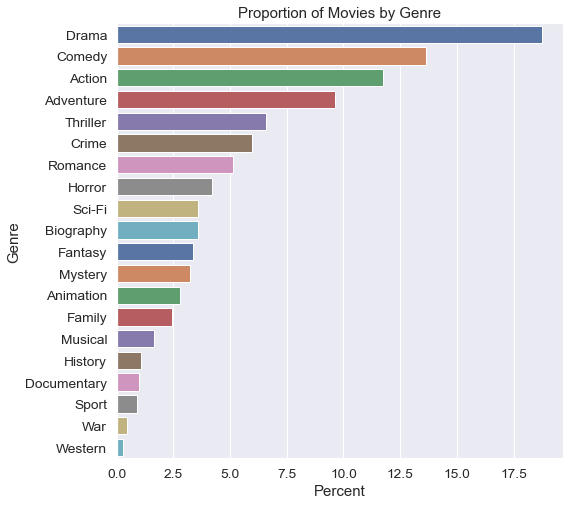

In [40]:
genre_counts = imdb.explode('genres')['genres'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax, palette='deep')
ax.set_title('Proportion of Movies by Genre')
ax.set_xlabel('Percent')
ax.set_ylabel('Genre')

In [29]:
imdb.to_json(os.path.join('cleanData', 'imdb.tn.basics.json'))

<AxesSubplot:ylabel='primary_title'>

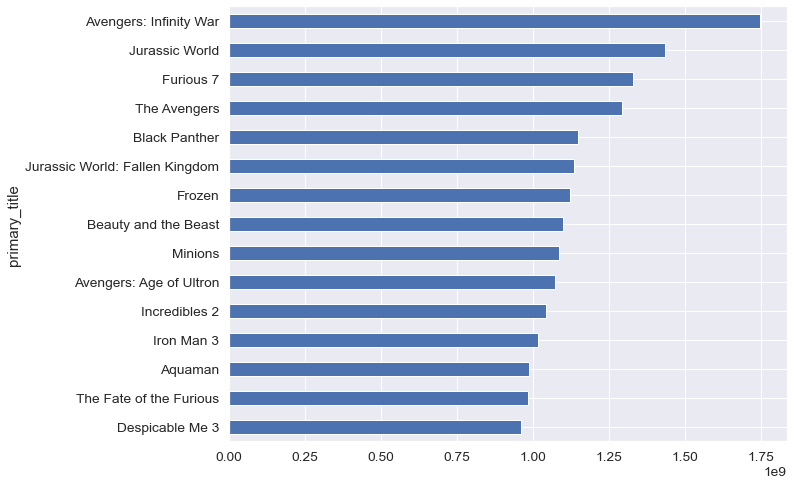

In [30]:
top_profit = imdb[['primary_title','worldwide_profit']].sort_values('worldwide_profit').tail(15)
top_profit.set_index('primary_title').plot.barh(figsize=(10, 8), legend=False)

<AxesSubplot:ylabel='genres'>

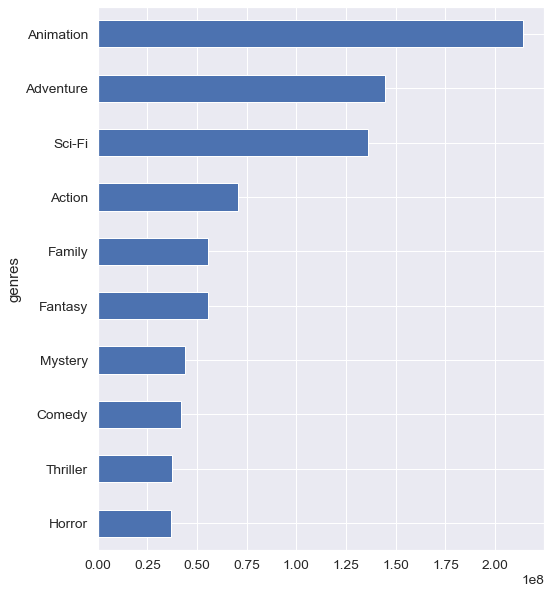

In [33]:
imdb.explode('genres').groupby('genres')['worldwide_profit'].median().sort_values().tail(10).plot.barh(figsize=(8, 10))

In [34]:
combos = pd.crosstab(imdb.explode('genres')['tconst'], imdb.explode('genres')['genres'])
combos = combos.sort_index(axis=1).sort_index(axis=0)
combos.to_json(os.path.join('precomputed', 'genre_combos.json'))
combos.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,
tt0359950,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0365907,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0369610,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
tt0376136,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0383010,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [35]:
imdb.set_index('tconst', inplace=True)

<AxesSubplot:title={'center':'Genre Correlation with Worldwide Profit'}, xlabel='Correlation', ylabel='Genre'>

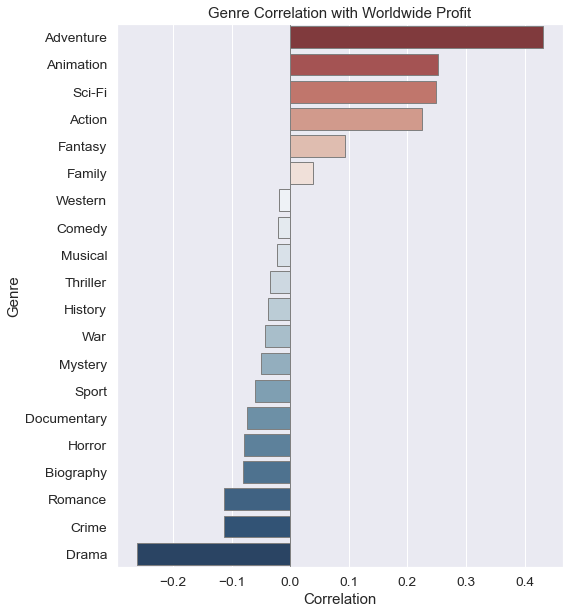

In [36]:
plotting.cat_correlation(combos, imdb['worldwide_profit'], 'Genre Correlation with Worldwide Profit', 'Genre')

It's hard to understand intuitively how genre could have anything approaching a linear relationship with profit. What does that even mean? It doesn't help to think about `combos`, the table of truth values created earlier. How could binary truth values have a linear relationship with profit, even in principle?

It all makes very good sense once you look at the following violin plots. The blobs indicate the location and cluster-density of the points in the distribution.

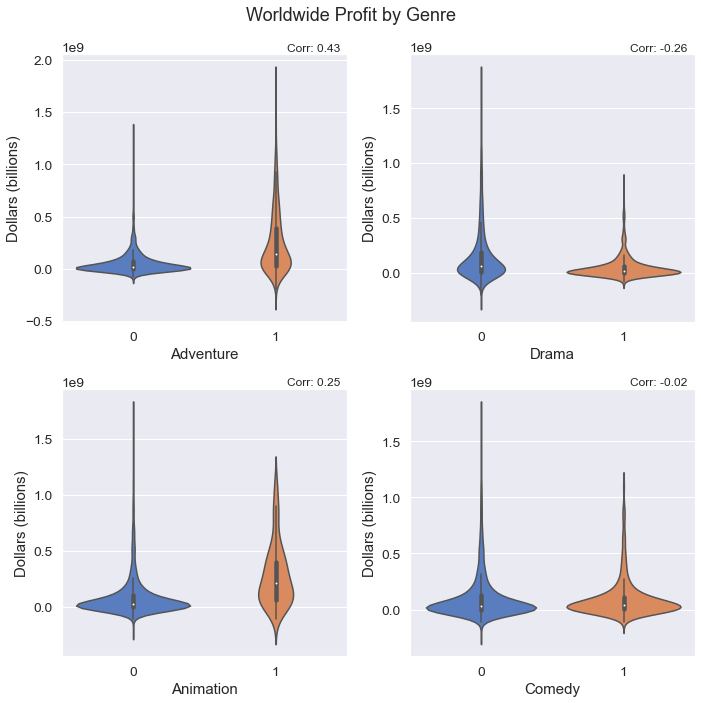

In [37]:
axes = plotting.boolean_violinplots(combos, imdb['worldwide_profit'], suptitle='Worldwide Profit by Genre', include=['Adventure', 'Drama', 'Animation', 'Comedy'], ylabel='Dollars (billions)', size=3, figsize=(10, 10))

<AxesSubplot:title={'center':'Genre Correlation with Worldwide ROI'}, xlabel='Correlation', ylabel='Genre'>

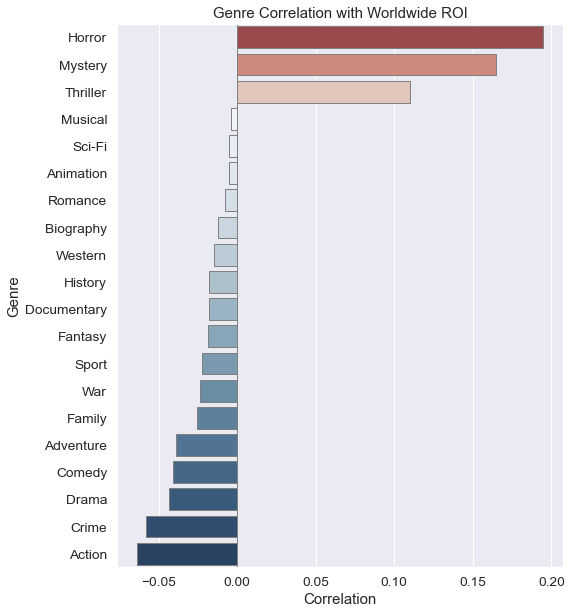

In [38]:
plotting.cat_correlation(combos, imdb['worldwide_roi'], 'Genre Correlation with Worldwide ROI', 'Genre')

In [39]:
quartile_labels = ['Low Budget', 'Mid-Low Budget', 'Mid-High Budget', 'High Budget']
imdb['budget_quartile'] = pd.qcut(imdb['production_budget'], 4, quartile_labels)
quartile_intervals = pd.qcut(imdb['production_budget'], 4).dtype.categories
global_roi_by_budget = combos.groupby(imdb['budget_quartile']).corrwith(imdb['worldwide_roi'])
global_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.047521,-0.036441,-0.017651,-0.031670,-0.082093,-0.058842,-0.048967,-0.120664,-0.039040,0.003213,-0.034934,0.246581,-0.041728,0.226627,-0.038139,-0.013672,-0.028522,0.178806,-0.025737,-0.023738
Mid-Low Budget,-0.114143,-0.043319,-0.006251,0.046910,0.039027,-0.125034,0.004846,0.023442,0.001859,-0.010431,0.011532,0.098724,0.032823,0.036655,0.023208,0.037576,-0.053416,0.053308,-0.082967,-0.039019
Mid-High Budget,-0.021730,-0.043935,-0.019407,-0.016470,-0.034357,-0.124481,-0.048794,-0.042146,-0.041521,-0.058455,-0.009947,0.021595,0.163115,0.027535,0.113471,0.041737,-0.013892,0.099117,-0.057770,0.015137
High Budget,-0.148393,0.153590,0.245077,0.009019,0.137946,-0.069370,-0.024475,-0.119603,-0.026314,-0.072886,-0.020623,-0.096173,0.090657,-0.024382,-0.108490,0.093229,-0.046550,-0.054345,-0.025478,-0.034459


array([<AxesSubplot:title={'center':'Low Budget\n\\$27,000 to \\$10,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'High Budget\n\\$61,500,000 to \\$410,600,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

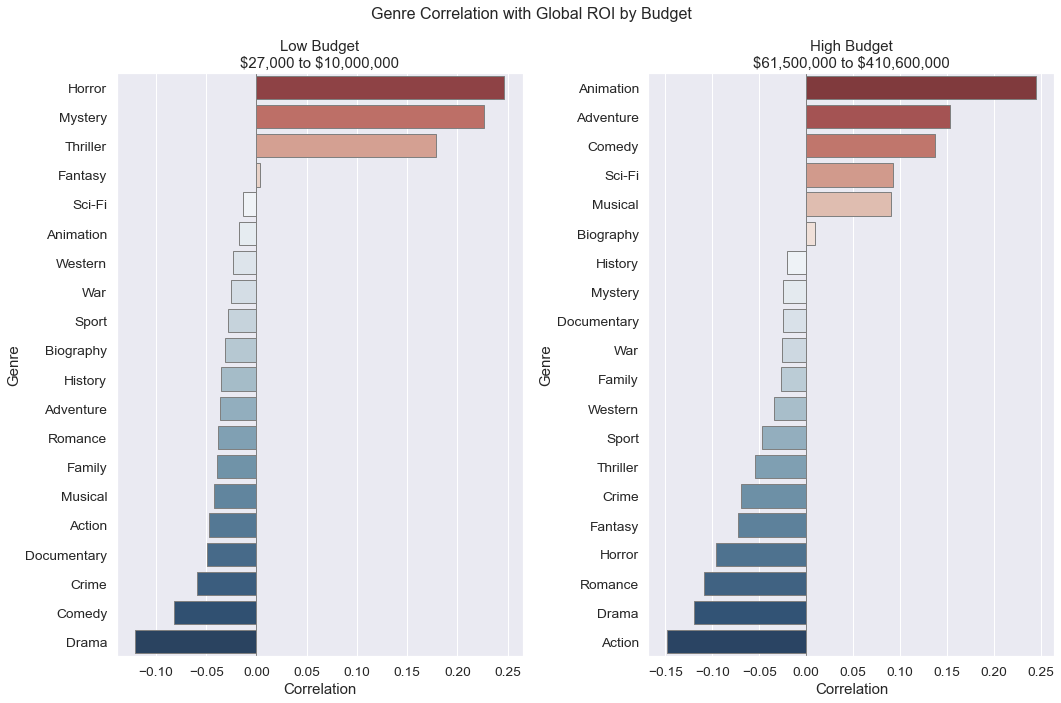

In [40]:
plotting.cat_corr_by_bins(global_roi_by_budget, 
                            'Low Budget', 
                            'High Budget', 
                            quartile_intervals[0], 
                            quartile_intervals[3], 
                            'Genre Correlation with Global ROI by Budget')

array([<AxesSubplot:title={'center':'Mid-Low Budget\n\\$10,000,000 to \\$28,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'Mid-High Budget\n\\$28,000,000 to \\$61,500,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

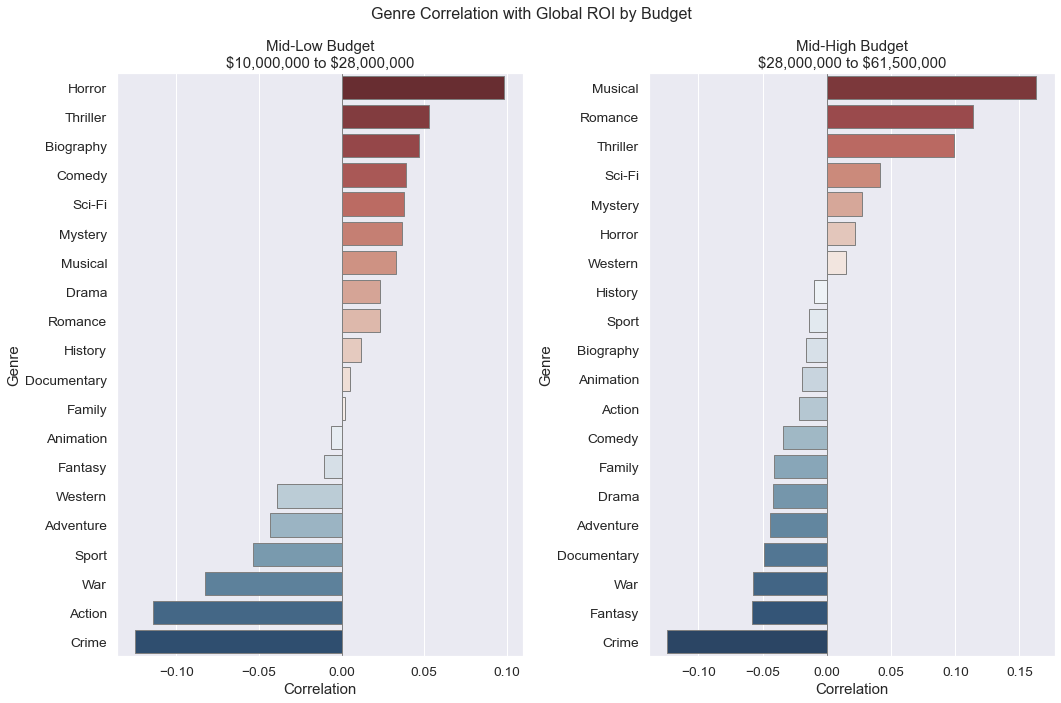

In [41]:
plotting.cat_corr_by_bins(global_roi_by_budget,
                            'Mid-Low Budget', 
                            'Mid-High Budget', 
                            quartile_intervals[1], 
                            quartile_intervals[2], 
                            'Genre Correlation with Global ROI by Budget')

In [42]:
domestic_roi_by_budget = combos.groupby(imdb['budget_quartile']).corrwith(imdb['domestic_roi'])
domestic_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.059691,-0.039606,-0.018587,-0.035543,-0.065161,-0.060940,-0.036264,-0.119858,-0.032049,0.010891,-0.037179,0.235730,-0.046213,0.205682,-0.025174,-0.014919,-0.025842,0.161407,-0.026141,-0.024243
Mid-Low Budget,-0.116429,-0.009912,0.014532,0.038398,0.094375,-0.119423,0.033340,-0.035159,0.076387,-0.028632,0.006542,0.078730,0.030732,-0.008091,0.040540,0.041166,-0.026850,0.004488,-0.098129,-0.046298
Mid-High Budget,-0.086648,-0.071062,-0.031273,0.024591,0.084883,-0.073085,-0.061189,-0.046862,0.001014,-0.081863,-0.051539,-0.024496,0.131953,-0.025587,0.096692,-0.028006,0.043867,0.016134,-0.059933,0.053799
High Budget,-0.181815,0.072110,0.218160,0.048765,0.185090,-0.081365,-0.054570,-0.084100,-0.003517,-0.098761,0.031682,-0.112233,0.110016,-0.004330,-0.083114,0.079838,-0.011165,-0.099235,-0.010649,-0.017732


array([<AxesSubplot:title={'center':'Low Budget\n\\$27,000 to \\$10,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'High Budget\n\\$61,500,000 to \\$410,600,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

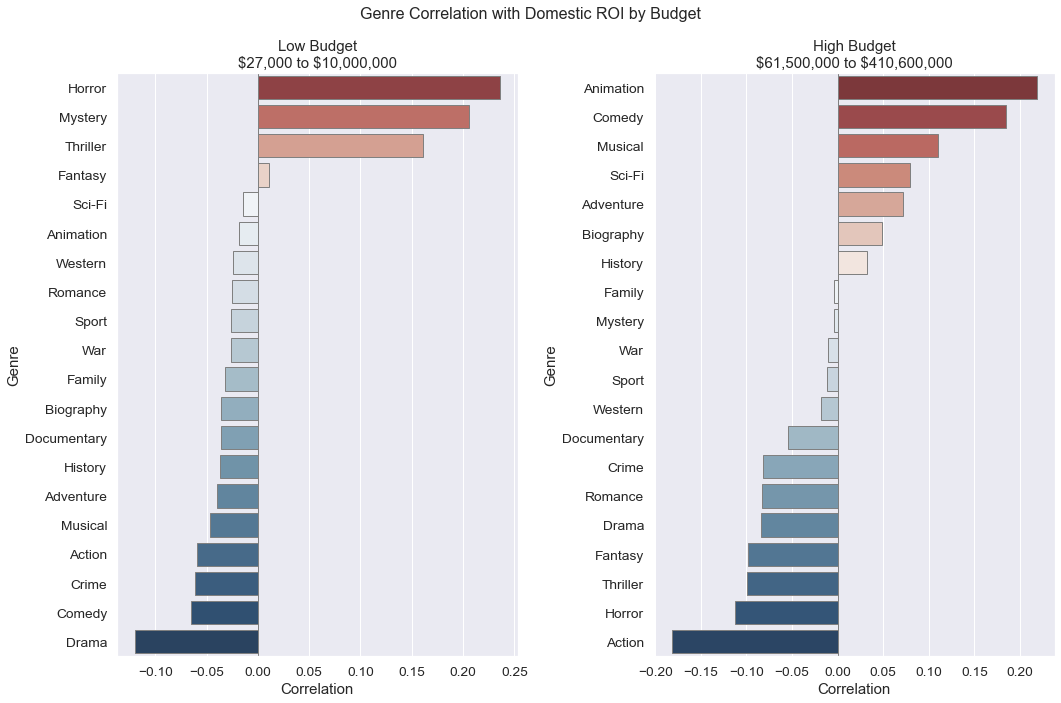

In [43]:
plotting.cat_corr_by_bins(domestic_roi_by_budget, 
                            'Low Budget', 
                            'High Budget', 
                            quartile_intervals[0], 
                            quartile_intervals[3], 
                            'Genre Correlation with Domestic ROI by Budget')